In [2]:
import pandas as pd
import boto3
import numpy as np
from collections import Counter
import os
import random
from datetime import datetime
import re, string
from typing import Dict

import torch, torchtext
import torchvision.models as models
from torchtext.data.utils import get_tokenizer
from torch.utils.data import TensorDataset, DataLoader
from torchtext.vocab import GloVe
from torch import nn, optim
from torch.nn import Module, Embedding, LSTM, RNN, GRU, Linear, Sequential, Dropout
from torch.nn.functional import sigmoid, relu, elu, tanh
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.nn.utils.rnn import PackedSequence


from tqdm import tqdm

SEED = 1234
N_SAMPLES = 100_000

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score

import time

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Today I'm going to use {device.type}")

Today I'm going to use cuda


In [4]:
chunks = pd.read_csv('../data/toxic_data.csv', chunksize=100000)
df = pd.concat(chunks)
df.head()

,id,comment_text,split,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,toxicity,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,threat,male,female,transgender,other_gender,heterosexual,homosexual_gay_or_lesbian,bisexual,other_sexual_orientation,christian,jewish,muslim,hindu,buddhist,atheist,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,identity_annotator_count,toxicity_annotator_count
0,1083994,He got his money... now he lies in wait till after the election in 2 yrs.... dirty politicians need to be afraid of Tar and feathers again... but they aren't and so the people get screwed.,train,2017-03-06 15:21:53.675241+00,21,NaN,317120,approved,0,0,0,2,0,0.373134,0.044776,0.089552,0.014925,0.000000,0.343284,0.014925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,67
1,650904,Mad dog will surely put the liberals in mental hospitals. Boorah,train,2016-12-02 16:44:21.329535+00,21,NaN,154086,approved,0,0,1,2,0,0.605263,0.013158,0.065789,0.013158,0.092105,0.565789,0.065789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76
2,5902188,And Trump continues his lifelong cowardice by not making this announcement himself.\n\nWhat an awful human being .....,train,2017-09-05 19:05:32.341360+00,55,NaN,374342,approved,1,0,2,3,7,0.666667,0.015873,0.031746,0.000000,0.047619,0.666667,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,63
3,7084460,"""while arresting a man for resisting arrest"".\n\nIf you cop-suckers can't see a problem with this, then go suck the barrel of a Glock.",test,2016-11-01 16:53:33.561631+00,13,NaN,149218,approved,0,0,0,0,0,0.815789,0.065789,0.552632,0.592105,0.000000,0.684211,0.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76
4,5410943,Tucker and Paul are both total bad ass mofo's.,train,2017-06-14 05:08:21.997315+00,21,NaN,344096,approved,0,0,0,1,0,0.550000,0.037500,0.337500,0.275000,0.037500,0.487500,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,80


In [5]:
df['comment_text'] = df['comment_text'].fillna("")
identity_columns = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
for col in identity_columns + ['toxicity']:
    df.loc[:, col] = np.where(df[col] >= 0.5, True, False)

In [6]:
train_df = df[df['split'] == 'train']
test_df = df[df['split'] != 'train']

In [7]:
sample = df
# sample = train_df.sample(N_SAMPLES, random_state=SEED, ignore_index=True)
train_text, val_text, train_label, val_label = train_test_split(sample['comment_text'], sample['toxicity'], test_size=0.2, random_state=SEED)
# train_text, train_label = sample['comment_text'], sample['toxicity']
test_text, test_label = test_df['comment_text'], test_df['toxicity']

train_label = torch.tensor(train_label.values, dtype=torch.float32).to(device)
val_label = torch.tensor(val_label.values, dtype=torch.float32).to(device) 
test_label = torch.tensor(test_label.values, dtype=torch.float32).to(device) 

In [8]:
train_text.shape, val_text.shape, test_text.shape

((1599612,), (399904,), (194641,))

In [9]:
misspell_dict = {"aren't": "are not", "can't": "cannot", "couldn't": "could not",
                 "didn't": "did not", "doesn't": "does not", "don't": "do not",
                 "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                 "he'd": "he would", "he'll": "he will", "he's": "he is",
                 "i'd": "I had", "i'll": "I will", "i'm": "I am", "isn't": "is not",
                 "it's": "it is", "it'll": "it will", "i've": "I have", "let's": "let us",
                 "mightn't": "might not", "mustn't": "must not", "shan't": "shall not",
                 "she'd": "she would", "she'll": "she will", "she's": "she is",
                 "shouldn't": "should not", "that's": "that is", "there's": "there is",
                 "they'd": "they would", "they'll": "they will", "they're": "they are",
                 "they've": "they have", "we'd": "we would", "we're": "we are",
                 "weren't": "were not", "we've": "we have", "what'll": "what will",
                 "what're": "what are", "what's": "what is", "what've": "what have",
                 "where's": "where is", "who'd": "who would", "who'll": "who will",
                 "who're": "who are", "who's": "who is", "who've": "who have",
                 "won't": "will not", "wouldn't": "would not", "you'd": "you would",
                 "you'll": "you will", "you're": "you are", "you've": "you have",
                 "'re": " are", "wasn't": "was not", "we'll": " will", "tryin'": "trying"}


def _get_misspell(misspell_dict):
    misspell_re = re.compile('(%s)' % '|'.join(misspell_dict.keys()))
    return misspell_dict, misspell_re


def replace_typical_misspell(text):
    misspellings, misspellings_re = _get_misspell(misspell_dict)

    def replace(match):
        return misspellings[match.group(0)]

    return misspellings_re.sub(replace, text)
    

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '_', '{', '}', '©', '^',
          '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']


def clean_text(x):
    x = str(x)
    for punct in puncts + list(string.punctuation):
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x


def clean_numbers(x):
    return re.sub('\d+', ' ', x)

In [10]:
# clean misspellings
train_text = train_text.apply(replace_typical_misspell)
val_text = val_text.apply(replace_typical_misspell)
test_text = test_text.apply(replace_typical_misspell)

# clean the text
train_text = train_text.apply(clean_text)
val_text = val_text.apply(clean_text)
test_text = test_text.apply(clean_text)

# clean numbers
train_text = train_text.apply(clean_numbers)
val_text = val_text.apply(clean_numbers)
test_text = test_text.apply(clean_numbers)

In [11]:
tokenizer = get_tokenizer("basic_english")
counter = Counter()
for line in train_text:
    counter.update(tokenizer(line))
    
# Create a vocabulary with words seen at least 3 (min_freq) times
vocab = torchtext.vocab.vocab(counter, min_freq=3)

In [12]:
# Add the unknown token and use it by default for unknown words
unk_token = '<unk>'
# vocab.insert_token(unk_token, 0)
vocab.set_default_index(0)

# Add the pad token Explanation https://huggingface.co/docs/transformers/pad_truncation
pad_token = '<pad>'
vocab.insert_token(pad_token, 1)

In [13]:
text_transform_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

In [14]:
#save vocab
torch.save(vocab, 'vocab_obj_pytorch.pth')

In [15]:
print(f"Before transform:\n{train_text.iloc[1666]}")
print(f"After transform:\n{text_transform_pipeline(train_text.iloc[1666])}")

Before transform:
There  '  s no excuse for what NK did to this young man  .   It cannot and should not go unanswered  .  
After transform:
[443, 29, 30, 293, 2243, 43, 296, 9113, 241, 3, 70, 839, 907, 11, 24, 633, 17, 81, 116, 341, 5455, 11]


In [16]:
def transformText(text_list, max_len):
    # Transform the text
    transformed_data = [text_transform_pipeline(text)[:max_len] for text in text_list]

    # Pad zeros if the text is shoter than max_len
    for data in transformed_data:
        data[len(data) : max_len] = np.ones(max_len - len(data))

    return torch.tensor(transformed_data, dtype=torch.int64)

In [17]:
#PARAMETERS
N_EPOCHES = 10
max_len = 100
batch_size = 128

# Size of the state vectors
lstm_hiden_size = 128
dense_hiden_size = 4 * lstm_hiden_size

# General NN training parameters
learning_rate = 0.0001

In [18]:
# Create data loaders
train_dataset = TensorDataset(
    transformText(train_text, max_len), train_label
)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset = TensorDataset(transformText(val_text, max_len), val_label)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = TensorDataset(transformText(test_text, max_len), test_label)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

/tmp/ipykernel_100/3562846554.py:9: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(transformed_data, dtype=torch.int64)


In [19]:
#Pretrained Word Embeddings ====> GloVe, FastText, CharNGram
#Let us try GloVe

glove = GloVe(name="6B", dim=300)
embedding_matrix = glove.get_vecs_by_tokens(vocab.get_itos())

In [20]:
embedding_matrix.shape

torch.Size([107482, 300])

In [21]:
# Embedding vector and vocabulary sizes
embed_size = 300  # glove.6B.300d.txt
vocab_size = len(vocab.get_itos())
vocab_size

107482

In [22]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x
    
class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix, lstm_hiden_size, dense_hiden_size):
        super(NeuralNet, self).__init__()
        max_features = embedding_matrix.shape[0]
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(embedding_matrix.clone().detach())
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.6)

        self.lstm1 = nn.LSTM(embed_size, lstm_hiden_size, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hiden_size * 2, lstm_hiden_size, bidirectional=True, batch_first=True)
    
        self.linear1 = nn.Linear(dense_hiden_size, dense_hiden_size)
        self.linear2 = nn.Linear(dense_hiden_size, dense_hiden_size)
        
        self.linear_out = nn.Linear(dense_hiden_size, 1)
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
        max_pool, _ = torch.max(h_lstm2, 1)
        
        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = relu(self.linear1(h_conc))
        h_conc_linear2  = relu(self.linear2(h_conc))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2       
        result = self.linear_out(hidden)

        return result

In [23]:
model = NeuralNet(embedding_matrix, lstm_hiden_size, dense_hiden_size)
# Setting our trainer
trainer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# We will use Binary Cross-entropy loss
cross_ent_loss = nn.BCEWithLogitsLoss(reduction='mean')

In [25]:
train_losses = []
val_losses = []
train_scores = []
val_scores = []

# Get the compute device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(N_EPOCHES):
    start = time.time()
    training_loss = 0
    val_loss = 0
    train_score = 0
    val_score = 0
    model.train()

    for data, target in tqdm(train_loader):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = cross_ent_loss(output.squeeze(1), target)
        trainer.zero_grad()
        loss.backward()
        trainer.step()
        training_loss += loss.item()
        try:
            train_score += roc_auc_score(target.cpu(), output.detach().cpu().numpy())
        except ValueError:
            pass

        
        
        
    model.eval()
    
    for data, target in tqdm(val_loader):
        data = data.to(device)
        target = target.to(device)
        val_predictions = torch.sigmoid(model(data)).squeeze(1)
        loss = cross_ent_loss(val_predictions, target)
        val_loss += loss.item()
        try:
            val_score += roc_auc_score(target.cpu(), val_predictions.detach().cpu().numpy())
        except ValueError:
            pass
        
        
    # Let's take the average losses
    training_loss = training_loss / len(train_label)
    val_loss = val_loss / len(val_label)
    train_score = train_score / len(train_label)
    val_score = val_score / len(val_label)
    
    train_losses.append(training_loss)
    val_losses.append(val_loss)
    train_scores.append(train_score)
    val_scores.append(val_score)

    end = time.time()
    print(
        f"Epoch {epoch}. Train_loss {training_loss}. Validation_loss {val_loss}. Seconds {end-start}"
    )

100%|██████████| 3125/3125 [00:31<00:00, 98.79it/s]


Epoch 0. Train_loss 0.0013111475270611984. Validation_loss 0.005538812699209998. Seconds 389.97866320610046


100%|██████████| 3125/3125 [00:33<00:00, 93.86it/s]


Epoch 1. Train_loss 0.001192368977337002. Validation_loss 0.005551861742620345. Seconds 379.2952404022217


100%|██████████| 3125/3125 [00:32<00:00, 96.09it/s]


Epoch 2. Train_loss 0.0011471499037754673. Validation_loss 0.005564987445422304. Seconds 403.1948449611664


100%|██████████| 3125/3125 [00:34<00:00, 90.29it/s]


Epoch 3. Train_loss 0.0011188527436172932. Validation_loss 0.0055570727455823. Seconds 395.5253460407257


100%|██████████| 3125/3125 [00:32<00:00, 95.94it/s]


Epoch 4. Train_loss 0.0010972754646097396. Validation_loss 0.005574134210728403. Seconds 403.01636123657227


100%|██████████| 3125/3125 [00:34<00:00, 90.41it/s]


Epoch 5. Train_loss 0.0010842716046533028. Validation_loss 0.005579326285119818. Seconds 402.0917909145355


100%|██████████| 3125/3125 [00:33<00:00, 93.74it/s]


Epoch 6. Train_loss 0.0010705223719880454. Validation_loss 0.005585691320088431. Seconds 405.9913296699524


100%|██████████| 3125/3125 [00:33<00:00, 92.84it/s]


Epoch 7. Train_loss 0.0010581153088626192. Validation_loss 0.00557066311656885. Seconds 406.6757414340973


100%|██████████| 3125/3125 [00:32<00:00, 95.55it/s]


Epoch 8. Train_loss 0.0010492928783268696. Validation_loss 0.00555825320190145. Seconds 382.7616925239563


100%|██████████| 3125/3125 [00:34<00:00, 91.59it/s]

Epoch 9. Train_loss 0.0010404555278918288. Validation_loss 0.005542338415211254. Seconds 405.51312160491943


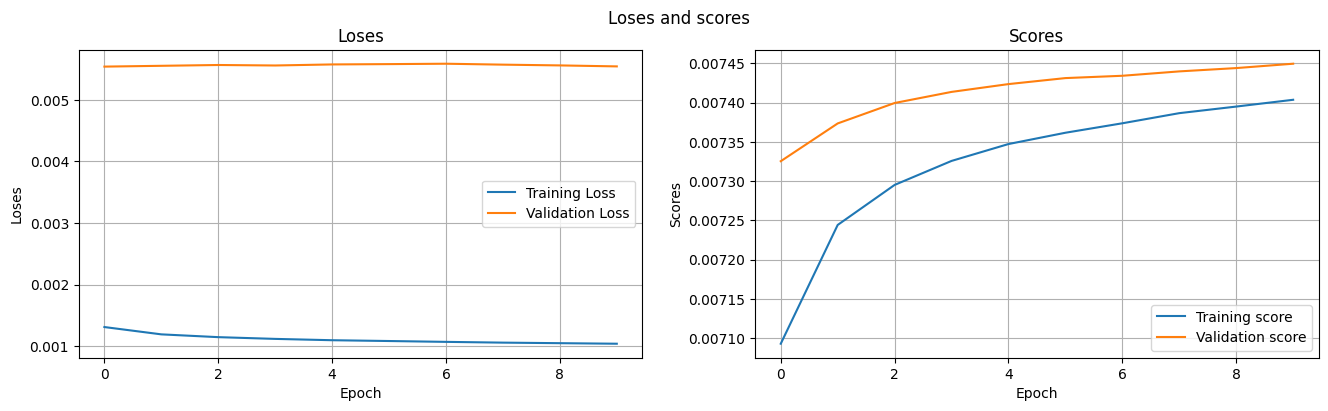

In [26]:
plt.rcParams['axes.grid'] = True

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('Loses and scores')
ax[0].plot(train_losses, label="Training Loss")
ax[0].plot(val_losses, label="Validation Loss")
ax[0].legend()
ax[0].set_title('Loses')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loses")
ax[1].plot(train_scores, label="Training score")
ax[1].plot(val_scores, label="Validation score")
ax[1].legend()
ax[1].set_title('Scores')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Scores")
plt.show()

In [27]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

model.eval()
test_predictions = []
for data, target in tqdm(test_loader):
    test_preds = model(data.to(device))
    test_predictions.extend(
        [sigmoid(test_pred[0]) for test_pred in test_preds.detach().cpu().numpy()]
    )

100%|██████████| 1521/1521 [00:15<00:00, 98.54it/s] 


In [28]:
sum(test_predictions), len(test_predictions)
oof_name = 'predicted_target'
test_df[oof_name] = test_predictions

In [29]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, oof_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[oof_name])

def compute_bpsn_auc(df, subgroup, label, oof_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[oof_name])

def compute_bnsp_auc(df, subgroup, label, oof_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[oof_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)
bias_metrics_df = compute_bias_metrics_for_model(test_df, identity_columns, oof_name, 'toxicity')
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
2,homosexual_gay_or_lesbian,1065,0.811942,0.825777,0.962205
6,black,1519,0.819045,0.821372,0.966588
7,white,2452,0.821433,0.829005,0.965468
5,muslim,2040,0.834900,0.860784,0.956672
4,jewish,835,0.901628,0.897469,0.962988
0,male,4386,0.904144,0.910577,0.958212
1,female,5155,0.904995,0.917657,0.953992
8,psychiatric_or_mental_illness,511,0.907582,0.872115,0.972044
3,christian,4226,0.921117,0.939509,0.946177


In [30]:
def calculate_overall_auc(df, oof_name):
    true_labels = df['toxicity']
    predicted_labels = df[oof_name]
    return roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
FINAL_SCORE = get_final_metric(bias_metrics_df, calculate_overall_auc(test_df, oof_name))
print(f"FINAL SCORE IS {FINAL_SCORE}")

FINAL SCORE IS 0.9125696308622693


In [31]:
!pwd

/home/studio-lab-user/sagemaker_exp/sandbox


In [46]:
PATH = '/home/studio-lab-user/sagemaker_exp/torch_models'
TODAY = datetime.today().strftime("%Y-%m-%d")
torch.save(model.state_dict(), f"{PATH}/torch_model_{TODAY}.pth")


### TESTING

In [57]:
upload_vocab = torch.load('../torch_models/vocab_obj_pytorch.pth')

In [58]:
# Define model
class TheModelClass(nn.Module):
    def __init__(self, embedding_matrix, lstm_hiden_size, dense_hiden_size):
        super(TheModelClass, self).__init__()
        max_features = embedding_matrix.shape[0]
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(embedding_matrix.clone().detach())
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.6)

        self.lstm1 = nn.LSTM(embed_size, lstm_hiden_size, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hiden_size * 2, lstm_hiden_size, bidirectional=True, batch_first=True)
    
        self.linear1 = nn.Linear(dense_hiden_size, dense_hiden_size)
        self.linear2 = nn.Linear(dense_hiden_size, dense_hiden_size)
        
        self.linear_out = nn.Linear(dense_hiden_size, 1)
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
        max_pool, _ = torch.max(h_lstm2, 1)
        
        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = relu(self.linear1(h_conc))
        h_conc_linear2  = relu(self.linear2(h_conc))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2       
        result = self.linear_out(hidden)

        return result

model = TheModelClass(embedding_matrix, lstm_hiden_size, dense_hiden_size)
# Setting our trainer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
embedding.weight 	 torch.Size([107482, 300])
lstm1.weight_ih_l0 	 torch.Size([512, 300])
lstm1.weight_hh_l0 	 torch.Size([512, 128])
lstm1.bias_ih_l0 	 torch.Size([512])
lstm1.bias_hh_l0 	 torch.Size([512])
lstm1.weight_ih_l0_reverse 	 torch.Size([512, 300])
lstm1.weight_hh_l0_reverse 	 torch.Size([512, 128])
lstm1.bias_ih_l0_reverse 	 torch.Size([512])
lstm1.bias_hh_l0_reverse 	 torch.Size([512])
lstm2.weight_ih_l0 	 torch.Size([512, 256])
lstm2.weight_hh_l0 	 torch.Size([512, 128])
lstm2.bias_ih_l0 	 torch.Size([512])
lstm2.bias_hh_l0 	 torch.Size([512])
lstm2.weight_ih_l0_reverse 	 torch.Size([512, 256])
lstm2.weight_hh_l0_reverse 	 torch.Size([512, 128])
lstm2.bias_ih_l0_reverse 	 torch.Size([512])
lstm2.bias_hh_l0_reverse 	 torch.Size([512])
linear1.weight 	 torch.Size([512, 512])
linear1.bias 	 torch.Size([512])
linear2.weight 	 torch.Size([512, 512])
linear2.bias 	 torch.Size([512])
linear_out.weight 	 torch.Size([1, 512])
linear_out.bias 	 torch.Size([1])
Op

In [59]:
upload_model = TheModelClass(embedding_matrix, lstm_hiden_size, dense_hiden_size)
upload_model.load_state_dict(torch.load(f"{PATH}/torch_model_{TODAY}.pth"))
upload_model.eval()

TheModelClass(
  (embedding): Embedding(107482, 300)
  (embedding_dropout): SpatialDropout(p=0.6, inplace=False)
  (lstm1): LSTM(300, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=512, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear_out): Linear(in_features=512, out_features=1, bias=True)
)

In [123]:
test_strings = ["Any news on the prizes ? Monika Kaczmarek", "give us some more time🙌 We'll contact with you when it will be ready 🚀","Hello Viktoryia Charnianina, is it critical to send the invoice within the specified period (last day of month - 5th of the next month)? I've send my invoice a bit earlier.",
                "Hello everyone. Please tell me who I can contact about my vacation? I have some questions about Unused day off. Thanks.",
               "Hi everyone! Hope you had a great Tuesday! Is there anybody who sells iPhone 12/13? I broke mine yesterday ",
               "Do we have any kind of comparison between Komfort and Komfort plus plans?",
"What if somebody wants to stay on a Komfort plan further? Do they need to fill up a questionnaire?",
"Nope smile You do not need to do anything. It will be prolonged automatically. ",
"""Hi!
Have I understood correctly that 'Declaration' that is mentioned above is called as "Formularz - medical insurance" in Sharepoint?"""
"I have found the answer))))",
"General those who has Standard last year, you will be automatically moved to Komfort ( still it will be free of charge for you). If you do not want to have any package, this is the last moment for you to let me know. ",
"General some of you started to receive your PZU declarations. Please do not worry if you haven't received yours yet or if you have received one of them ( medical/life insurance) but haven't received the rest. You'll receive the remaining files next week. It's just to many declarations to deal with. Hope for your understanding",
"please mind couple of things when you send me scans of your documents: 1) I just need PZU Life Insurance scan; 2) You need to send 1st and 2nd page as one PDF file and send it to me  ( just picture of your signature has no value); 3) Even if you sent a scan, you still need to bring/mail us the oginal ( also original of medical insurance if you have one). In case you haven't received password to your files, it is: 2022 "]

In [124]:
def determine_toxicity(text):
    [replace_typical_misspell, clean_text, clean_numbers]
    text = replace_typical_misspell(text)
    text = clean_text(text)
    text = clean_numbers(text)
    
    transformed = transformText([text], 100)
    test_loader = DataLoader(transformed, batch_size=batch_size)
    upload_model = TheModelClass(embedding_matrix, lstm_hiden_size, dense_hiden_size)
    upload_model.load_state_dict(torch.load(f"{PATH}/torch_model_{TODAY}.pth"))
    upload_model.eval()
    test_predictions = []
    for data in test_loader:
        test_preds = upload_model(data)
        test_predictions.extend(
            [sigmoid(test_pred[0]) for test_pred in test_preds.detach().cpu().numpy()]
        )
    return test_predictions[0]


In [125]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [126]:
for text in test_strings:
    print(f"{text}, toxicity = {determine_toxicity(text)}")

/tmp/ipykernel_100/3562846554.py:9: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(transformed_data, dtype=torch.int64)


Any news on the prizes ? Monika Kaczmarek, toxicity = 0.0026159089221749533
give us some more time🙌 We'll contact with you when it will be ready 🚀, toxicity = 0.011255433559864048
Hello Viktoryia Charnianina, is it critical to send the invoice within the specified period (last day of month - 5th of the next month)? I've send my invoice a bit earlier., toxicity = 0.0003022625042109019
Hello everyone. Please tell me who I can contact about my vacation? I have some questions about Unused day off. Thanks., toxicity = 0.0004920312795431989
Hi everyone! Hope you had a great Tuesday! Is there anybody who sells iPhone 12/13? I broke mine yesterday , toxicity = 0.0011299277615885526
Do we have any kind of comparison between Komfort and Komfort plus plans?, toxicity = 0.0019972811668783636
What if somebody wants to stay on a Komfort plan further? Do they need to fill up a questionnaire?, toxicity = 0.0012617091600208232
Nope smile You do not need to do anything. It will be prolonged automaticall

In [2]:
import logging
import boto3
from botocore.exceptions import ClientError
import os


def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = os.path.basename(file_name)

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [ ]:
bucket = 'godelsagemaker'

In [8]:
a = pd.DataFrame([True, True, False, True], columns=['the_values'])
a.the_values.astype('float32')

0    1.0
1    1.0
2    0.0
3    1.0
Name: the_values, dtype: float32